<center>
<h4>Diplomatura AACSyA 2018 - FaMAF - UNC</h4>
<h1>Aprendizaje No Supervisado</h1>
<h2>Práctico 2 - Sistemas de recomendación</h2>
<hr>
Por David Gonzalez <leonardo.david.gonzalez@gmail.com> y Facundo Díaz Cobos <facundo.diaz.cobos@gmail.com>
</center>
<br/>
    


# Objetivos

En este práctico tendrán que integrar en la notebook el sistema de recomendación basado en contenido que se propone en http://nbviewer.jupyter.org/github/khanhnamle1994/movielens/blob/master/Content_Based_ and_Collaborative_Filtering_Models.ipynb.

# Entrega

Entregar un notebook documentado a través de slack, antes del día 7 de septiembre.

___
# Sistema de Recomendación de libros Goodreads


Usamos como dataset el de https://www.goodreads.com/
que funciona com una comunidad de lectores. El actual dueño es Amazon.
Nos basamos en el dataset de kaggle: https://www.kaggle.com/bshirude2/goodreads-content-based-book-recommendation/data
En el propuesto por el pdf y algunos kernels de kaggle sobre motores de recomendacion tambien. 

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS


In [2]:
books = pd.read_csv('input/books.csv', encoding = "ISO-8859-1")
ratings = pd.read_csv('input/ratings.csv', encoding = "ISO-8859-1")
book_tags = pd.read_csv('input/book_tags.csv', encoding = "ISO-8859-1")
tags = pd.read_csv('input/tags.csv')
tags_join_DF = pd.merge(book_tags, tags, left_on='tag_id', right_on='tag_id', how='inner')


## Analizamos un poco los datos

In [3]:
books.columns

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')

In [4]:
print("Book shape: " + str(books.shape))
books.head(3)

Book shape: (10000, 23)


,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


In [5]:
print("ratings shape: " + str(ratings.shape))
ratings.head(3)

ratings shape: (981756, 3)


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5


In [6]:
tags_join_DF.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,2,30574,24549,to-read
2,3,30574,496107,to-read
3,5,30574,11909,to-read
4,6,30574,298,to-read


# Exploración de Datos
## Títulos
Creamos una nube de palabras para ver que Palabras se repiten más en los títulos de los libros

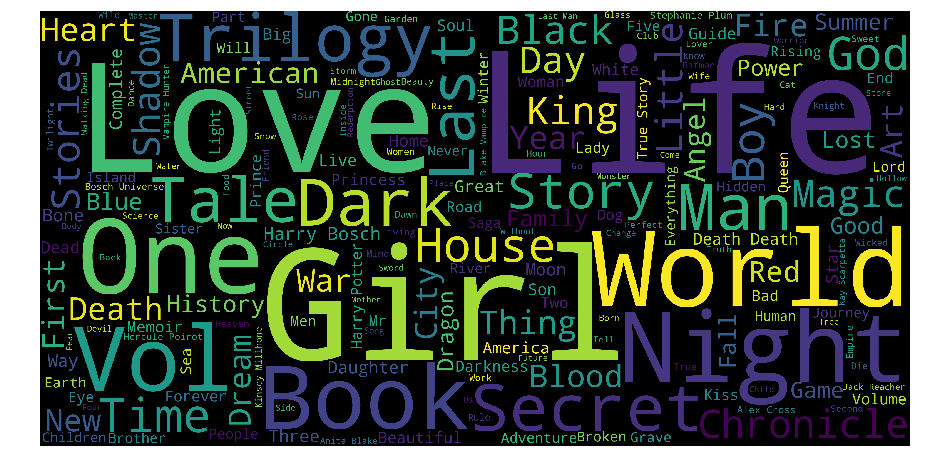

In [7]:

books['title'] = books['title'].fillna("").astype('str')
title_corpus = ' '.join(books['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

Se pueden apreciar los titulos mas comunes, obviamente aparecen trilogy a demas de las palabras life y love, girl y wold
### Ratings
Ahora Analizamos la distribucion de los ratings

In [8]:
# Get summary statistics of rating
ratings['rating'].describe()

count    981756.000000
mean          3.856534
std           0.983941
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


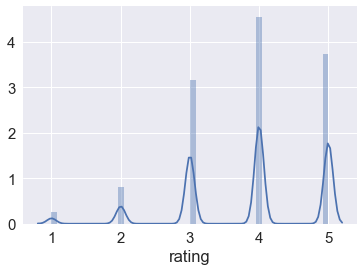

In [9]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

Podemos obvservar que la mayoria voto con 4, seguidos de 5 y 3. Muy pocos votaron con 1 y 2. No esta distribuido uniformemente.
### Autores
 Una suposición básica es que los autores suelen escribir libros generalmente parecidos. 
Vamos a mostrar en una tabla cuales son los autores que mas escribieron.

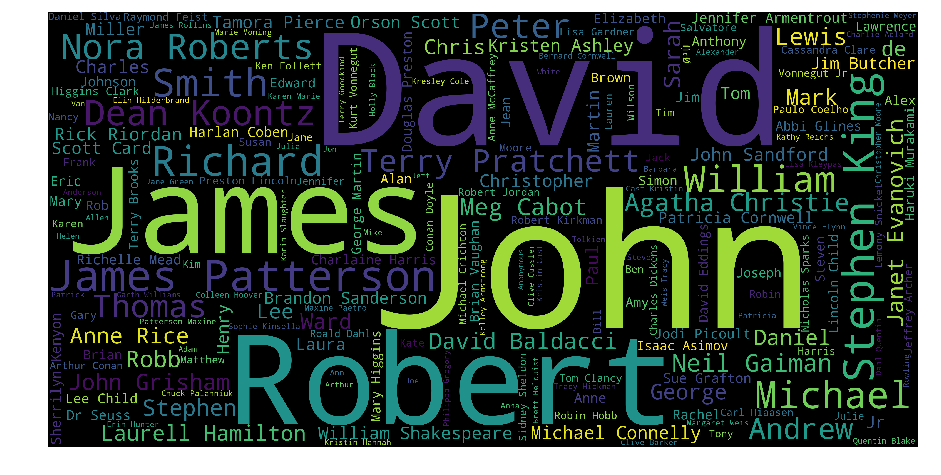

In [10]:

books['authors'] = books['authors'].fillna("").astype('str')
title_corpus = ' '.join(books['authors'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

 Desgraciadamente los nombres de los autores a veces aprecen separados, esperabamos que todos sean escritos como Stephen King o Nora Roberts.
 
Vamos a aplicar TfidfVectorizer a los autores y quitarle las stop words a ver que sucede

## Hay 2 Tipos de motores de recomendación

### 1. Basados en contenido

El recomendador basado en el contenido se basa en la similitud de los elementos que se recomiendan. La idea básica es que si te gusta un artículo, también te gustará un artículo "similar". Por lo general, funciona bien cuando es fácil determinar el contexto / propiedades de cada elemento.

Un recomendador basado en contenido funciona con datos que el usuario proporciona, en este caso las clasificaciones de las peliculas de MovieLens. En función de esos datos, se genera un perfil de usuario, que luego se utiliza para hacer sugerencias al usuario de nuevas pelicuas. A medida que el usuario proporciona más calificaciones, el motor se vuelve cada vez más preciso.

### 2. Filtrado colaborativo

El "Collaborative Filtering Recommender" se basa completamente en el comportamiento pasado y no en el contexto. Más específicamente, se basa en la similitud de preferencias, gustos y elecciones de dos usuarios. Analiza cuán similares son los gustos de un usuario a otro y hace recomendaciones sobre la base de eso.

Por ejemplo, si al usuario A le gustan las películas 1, 2, 3 y al usuario B le gustan las películas 2,3,4, entonces tienen intereses similares y A debería gustarle a la película 4 y B debería gustarle la película 1. 

En general, el filtrado colaborativo es el caballo de batalla de los motores de recomendación. El algoritmo tiene una propiedad muy interesante de poder hacer el aprendizaje de características por sí mismo, lo que significa que puede comenzar a aprender por sí mismo qué características usar. 

Se puede dividir en  Filtrado colaborativo basado en memoria  y  Filtrado colaborativo basado en modelo.

![rec-systems](rec-systems.png)

## Modelo de recomendación basado en el contenido

### Teoría

Los conceptos de Frecuencia de término (TF) y Frecuencia inversa de documento (IDF)
se utilizan en sistemas de información y también en mecanismos de filtrado basados
en contenido (como un recomendador basado en contenido).
Se usan para determinar la importancia relativa de un documento / artículo / noticia / película, etc.

TF es simplemente la frecuencia de una palabra en un documento. 
IDF es la inversa de la frecuencia del documento entre todo el corpus de documentos. 
TF-IDF se utiliza principalmente por dos motivos: supongamos que buscamos 
    
"** los resultados de los últimos juegos europeos de Futbol **" en Google.

Es cierto que las palabras como "el", "los", "de" ocurrirán con más frecuencia que "** juegos europeos de Futbol **" 
pero la importancia relativa de ** juegos europeos de Futbol ** es más alta que el punto de vista de la búsqueda.
En tales casos, la ponderación TF-IDF niega el efecto de las palabras de alta frecuencia para determinar 
la importancia de un elemento (documento).



### Implementación del un Montor de Recomendacion basado en contenido.
Utilizamos la Similitud coseno para calcular una cantidad numérica que denote la similitud entre dos películas. Ya que hemos utilizado el Vectorizador TF-IDF, al calcular el Producto Punto, nos dará directamente el Puntaje de Similaridad. Utilizaremos kernel lineal de sklearn.

In [11]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(books['authors'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [12]:
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Tenemos ahora la matriz de similitud de coseno de los pares. El siguiente paso es escribir una función que devuelva los 20 libros más similares en función de la puntuación de similitud del coseno.

In [13]:
titles = books['title']
indices = pd.Series(books.index, index=books['title'])

def recommendator(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

### Y eso seria todo en realidad, lo complicado es obtener la matriz
Lo probamos ahora

In [14]:
recommendator('The Hobbit').head(20)

18      The Fellowship of the Ring (The Lord of the Ri...
154            The Two Towers (The Lord of the Rings, #2)
160     The Return of the King (The Lord of the Rings,...
188     The Lord of the Rings (The Lord of the Rings, ...
963     J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
4975        Unfinished Tales of NÃºmenor and Middle-Earth
2308                               The Children of HÃºrin
610              The Silmarillion (Middle-Earth Universe)
8271                   The Complete Guide to Middle-Earth
1128     The History of the Hobbit, Part One: Mr. Baggins
465                             The Hobbit: Graphic Novel
0                 The Hunger Games (The Hunger Games, #1)
1       Harry Potter and the Sorcerer's Stone (Harry P...
2                                 Twilight (Twilight, #1)
3                                   To Kill a Mockingbird
4                                        The Great Gatsby
5                                  The Fault in Our Stars
7             

# Vemos ahora las etiquetas asociadas a un libro.

In [15]:
tags.tail()

,tag_id,tag_name
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ
34251,34251,ｆａｖｏｕｒｉｔｅｓ


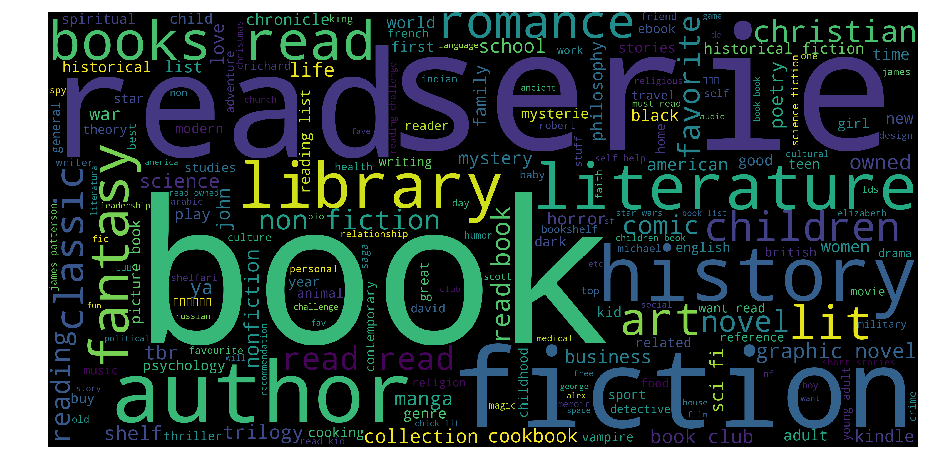

In [16]:
tags['tag_name'] = tags['tag_name'].fillna("").astype('str')
title_corpus = ' '.join(tags['tag_name'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [17]:
books_with_tags = pd.merge(books, tags_join_DF, left_on='book_id', right_on='goodreads_book_id', how='inner')
tf1 = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix1 = tf1.fit_transform(books_with_tags['tag_name'].head(10000))
cosine_sim1 = linear_kernel(tfidf_matrix1, tfidf_matrix1)
cosine_sim1

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [18]:
titles1 = books['title']
indices1 = pd.Series(books.index, index=books['title'])
def tags_recommendations(title):
    idx = indices1[title]
    sim_scores = list(enumerate(cosine_sim1[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

In [19]:
tags_recommendations('The Hobbit').head(20)

16                  Catching Fire (The Hunger Games, #2)
31                                       Of Mice and Men
107         Confessions of a Shopaholic (Shopaholic, #1)
125                            Dune (Dune Chronicles #1)
149                                         The Red Tent
206               One for the Money (Stephanie Plum, #1)
214                                     Ready Player One
231                  The Gunslinger (The Dark Tower, #1)
253               Shiver (The Wolves of Mercy Falls, #1)
313                              Inkheart (Inkworld, #1)
325                                       White Oleander
405       The New Drawing on the Right Side of the Brain
412                                 The Three Musketeers
425                              A Confederacy of Dunces
505                          The One (The Selection, #3)
513                    The Adventures of Sherlock Holmes
525                  Darkly Dreaming Dexter (Dexter, #1)
566                            

### Devuelve otros libros relacionados, pero no devuelve todos los del señor de los anillos, hay que utilizar los dos.

In [20]:
temp_df = books_with_tags.groupby('book_id')['tag_name'].apply(' '.join).reset_index()
books = pd.merge(books, temp_df, left_on='book_id', right_on='book_id', how='inner')
books['corpus'] = (pd.Series(books[['authors', 'tag_name']]
                .fillna('')
                .values.tolist()
                ).str.join(' '))

Ahora si, probemos armar una matriz y la funcion de nuevo!

In [21]:
all_together = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix_corpus = all_together.fit_transform(books['corpus'])
cosine_sim = linear_kernel(tfidf_matrix_corpus, tfidf_matrix_corpus)
titles = books['title']
indices = pd.Series(books.index, index=books['title'])

def corpus_recommendations(title):
    idx = indices1[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

corpus_recommendations("The Hobbit")

188     The Lord of the Rings (The Lord of the Rings, ...
154            The Two Towers (The Lord of the Rings, #2)
160     The Return of the King (The Lord of the Rings,...
18      The Fellowship of the Ring (The Lord of the Ri...
610              The Silmarillion (Middle-Earth Universe)
4975        Unfinished Tales of NÃºmenor and Middle-Earth
2308                               The Children of HÃºrin
963     J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
465                             The Hobbit: Graphic Novel
8271                   The Complete Guide to Middle-Earth
1366    The Once and Future King (The Once and Future ...
1321              The Last Unicorn (The Last Unicorn, #1)
53      The Hitchhiker's Guide to the Galaxy (Hitchhik...
367             The Subtle Knife (His Dark Materials, #2)
61            The Golden Compass (His Dark Materials, #1)
479           The Amber Spyglass (His Dark Materials, #3)
936          His Dark Materials (His Dark Materials #1-3)
331      The M

## Resultado
Ahora si devuelve libros similares entre los que se encuentran los del seños de los anillos el silmarilion, etc!